In [93]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
#import pyyawt


def notch_filter(x, samplerate, plot=False):
    x = x - np.mean(x)

    high_cutoff_notch = 59 / (samplerate / 2)
    low_cutoff_notch = 61 / (samplerate / 2)

    [b, a] = signal.butter(4, [high_cutoff_notch, low_cutoff_notch], btype='stop')

    x_filt = signal.filtfilt(b, a, x.T)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt.T, 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def bp_filter(x, low_f, high_f, samplerate, plot=False):
    # x = x - np.mean(x)

    low_cutoff_bp = low_f / (samplerate / 2)
    high_cutoff_bp = high_f / (samplerate / 2)

    [b, a] = signal.butter(5, [low_cutoff_bp, high_cutoff_bp], btype='bandpass')

    x_filt = signal.filtfilt(b, a, x)

    if plot:
        t = np.arange(0, len(x) / samplerate, 1 / samplerate)
        plt.plot(t, x)
        plt.plot(t, x_filt, 'k')
        plt.autoscale(tight=True)
        plt.xlabel('Time')
        plt.ylabel('Amplitude (mV)')
        plt.show()

    return x_filt


def plot_signal(x, samplerate, chname):
    t = np.arange(0, len(x) / samplerate, 1 / samplerate)
    print(t)
    plt.plot(t, x)
    plt.autoscale(tight=True)
    plt.xlabel('Time')
    plt.ylabel('Amplitude (mV)')
    plt.title(chname)
    plt.show()


def denoisewavelet(x1, level=5):
    xd, cxd, lxd = pyyawt.wden(x1, 'minimaxi', 's', 'mln', level, 'db5')
    return xd

In [94]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pywt


def features_estimation(signal, channel_name, fs, frame, step, plot=False):
    """
    Compute time, frequency and time-frequency features from signal.
    :param signal: numpy array signal.
    :param channel_name: string variable with the EMG channel name in analysis.
    :param fs: int variable with the sampling frequency used to acquire the signal
    :param frame: sliding window size
    :param step: sliding window step size
    :param plot: bolean variable to plot estimated features.
    :return: total_feature_matrix -- python Dataframe with .
    :return: features_names -- python list with
    """

    features_names = ['VAR', 'RMS', 'IEMG', 'MAV', 'LOG', 'WL', 'ACC', 'DASDV', 'ZC', 'WAMP', 'MYOP', "FR", "MNP", "TP",
                      "MNF", "MDF", "PKF", "WENT"]

    time_matrix = time_features_estimation(signal, frame, step)
    frequency_matrix = frequency_features_estimation(signal, fs, frame, step)
    time_frequency_matrix = time_frequency_features_estimation(signal, frame, step)
    total_feature_matrix = pd.DataFrame(np.column_stack((time_matrix, frequency_matrix, time_frequency_matrix)).T,
                                        index=features_names)

    print('EMG features were from channel {} extracted successfully'.format(channel_name))

    if plot:
        plot_features(signal, channel_name, fs, total_feature_matrix, step)

    return total_feature_matrix, features_names


def time_features_estimation(signal, frame, step):
    """
    Compute time features from signal using sliding window method.
    :param signal: numpy array signal.
    :param frame: sliding window size.
    :param step: sliding window step size.
    :return: time_features_matrix: narray matrix with the time features stacked by columns.
    """

    variance = []
    rms = []
    iemg = []
    mav = []
    log_detector = []
    wl = []
    aac = []
    dasdv = []
    zc = []
    wamp = []
    myop = []

    th = np.mean(signal) + 3 * np.std(signal)

    for i in range(frame, signal.size, step):
        x = signal[i - frame:i]

        variance.append(np.var(x))
        rms.append(np.sqrt(np.mean(x ** 2)))
        iemg.append(np.sum(abs(x)))  # Integral
        mav.append(np.sum(np.absolute(x)) / frame)  # Mean Absolute Value
        log_detector.append(np.exp(np.sum(np.log10(np.absolute(x))) / frame))
        wl.append(np.sum(abs(np.diff(x))))  # Wavelength
        aac.append(np.sum(abs(np.diff(x))) / frame)  # Average Amplitude Change
        dasdv.append(
            math.sqrt((1 / (frame - 1)) * np.sum((np.diff(x)) ** 2)))  # Difference absolute standard deviation value
        zc.append(zcruce(x, th))  # Zero-Crossing
        wamp.append(wilson_amplitude(x, th))  # Willison amplitude
        myop.append(myopulse(x, th))  # Myopulse percentage rate

    time_features_matrix = np.column_stack((variance, rms, iemg, mav, log_detector, wl, aac, dasdv, zc, wamp, myop))
    print("time_features")
    print(time_features_matrix)
    return time_features_matrix


def frequency_features_estimation(signal, fs, frame, step):
    """
    Compute frequency features from signal using sliding window method.
    :param signal: numpy array signal.
    :param fs: sampling frequency of the signal.
    :param frame: sliding window size
    :param step: sliding window step size
    :return: frequency_features_matrix: narray matrix with the frequency features stacked by columns.
    """

    fr = []
    mnp = []
    tot = []
    mnf = []
    mdf = []
    pkf = []

    for i in range(frame, signal.size, step):
        x = signal[i - frame:i]
        frequency, power = spectrum(x, fs)

        fr.append(frequency_ratio(frequency, power))  # Frequency ratio
        mnp.append(np.sum(power) / len(power))  # Mean power
        tot.append(np.sum(power))  # Total power
        mnf.append(mean_freq(frequency, power))  # Mean frequency
        mdf.append(median_freq(frequency, power))  # Median frequency
        pkf.append(frequency[power.argmax()])  # Peak frequency

    frequency_features_matrix = np.column_stack((fr, mnp, tot, mnf, mdf, pkf))

    return frequency_features_matrix


def time_frequency_features_estimation(signal, frame, step):
    """
    Compute time-frequency features from signal using sliding window method.
    :param signal: numpy array signal.
    :param frame: sliding window size
    :param step: sliding window step size
    :return: h_wavelet: list
    """
    h_wavelet = []

    for i in range(frame, signal.size, step):
        x = signal[i - frame:i]

        E_a, E = wavelet_energy(x, 'db2', 4)
        E.insert(0, E_a)
        E = np.asarray(E) / 100

        h_wavelet.append(-np.sum(E * np.log2(E)))

    return h_wavelet


def wilson_amplitude(signal, th):
    x = abs(np.diff(signal))
    umbral = x >= th
    return np.sum(umbral)


def myopulse(signal, th):
    umbral = signal >= th
    return np.sum(umbral) / len(signal)


def spectrum(signal, fs):
    m = len(signal)
    n = next_power_of_2(m)
    y = np.fft.fft(signal, n)
    yh = y[0:int(n / 2 - 1)]
    fh = (fs / n) * np.arange(0, n / 2 - 1, 1)
    power = np.real(yh * np.conj(yh) / n)

    return fh, power


def frequency_ratio(frequency, power):
    power_low = power[(frequency >= 30) & (frequency <= 250)]
    power_high = power[(frequency > 250) & (frequency <= 500)]
    ULC = np.sum(power_low)
    UHC = np.sum(power_high)

    return ULC / UHC


def shannon(x):
    N = len(x)
    nb = 19
    hist, bin_edges = np.histogram(x, bins=nb)
    counts = hist / N
    nz = np.nonzero(counts)

    return np.sum(counts[nz] * np.log(counts[nz]) / np.log(2))


def zcruce(X, th):
    th = 0
    cruce = 0
    for cont in range(len(X) - 1):
        can = X[cont] * X[cont + 1]
        can2 = abs(X[cont] - X[cont + 1])
        if can < 0 and can2 > th:
            cruce = cruce + 1
    return cruce


def mean_freq(frequency, power):
    num = 0
    den = 0
    for i in range(int(len(power) / 2)):
        num += frequency[i] * power[i]
        den += power[i]

    return num / den


def median_freq(frequency, power):
    power_total = np.sum(power) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += power[i]
        errel = (power_total - temp) / power_total
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return frequency[i]


def wavelet_energy(x, mother, nivel):
    coeffs = pywt.wavedecn(x, wavelet=mother, level=nivel)
    arr, _ = pywt.coeffs_to_array(coeffs)
    Et = np.sum(arr ** 2)
    cA = coeffs[0]
    Ea = 100 * np.sum(cA ** 2) / Et
    Ed = []

    for k in range(1, len(coeffs)):
        cD = list(coeffs[k].values())
        cD = np.asarray(cD)
        Ed.append(100 * np.sum(cD ** 2) / Et)

    return Ea, Ed


def next_power_of_2(x):
    return 1 if x == 0 else 2 ** (x - 1).bit_length()


def med_freq(f, P):
    Ptot = np.sum(P) / 2
    temp = 0
    tol = 0.01
    errel = 1
    i = 0

    while abs(errel) > tol:
        temp += P[i]
        errel = (Ptot - temp) / Ptot
        i += 1
        if errel < 0:
            errel = 0
            i -= 1

    return f[i]


def plot_features(signal, channel_name, fs, feature_matrix, step):
    """
    xxxs
    Argument:
    signal -- python numpy array representing recording of a signal.
    channel_name -- string variable with the EMG channel name in analysis.
    fs -- int variable with the sampling frequency used to acquire the signal.
    feature_matrix -- python Dataframe ...
    step -- int variable with the step size used in the sliding window method.
    """

    ts = np.arange(0, len(signal) / fs, 1 / fs)
    # for idx, f in enumerate(tfeatures.T):
    for key in feature_matrix.T:
        tf = step * (np.arange(0, len(feature_matrix.T[key]) / fs, 1 / fs))
        fig = plt.figure()

        ax = fig.add_subplot(111, label="1")
        ax2 = fig.add_subplot(111, label="2", frame_on=False)
        ax.plot(ts, signal, color="C0")
        ax.autoscale(tight=True)
        plt.title(channel_name + ": " + key)
        ax.set_xlabel("Time")
        ax.set_ylabel("mV")

        ax2.plot(tf, feature_matrix.T[key], color="red")
        ax2.yaxis.tick_right()
        ax2.autoscale(tight=True)
        ax2.set_xticks([])
        ax2.set_yticks([])
        mng = plt.get_current_fig_manager()
        mng.window.state('zoomed')
        plt.show()



In [95]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import pandas as pd

signal_path = "/content/drive/MyDrive/Major Project/Subject_9_Movement_1.xlsx"



[0.00000e+00 5.00000e-04 1.00000e-03 ... 2.99985e+01 2.99990e+01
 2.99995e+01]


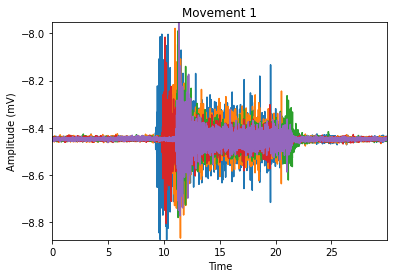

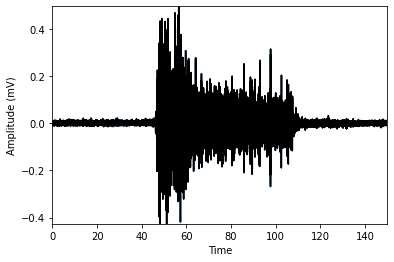

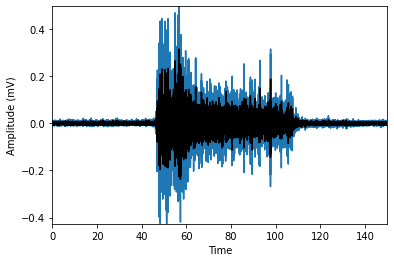

[ 0.00046382 -0.0050346  -0.00720896 ... -0.00384697 -0.00315429
  0.00013162]
time_features
[[6.05416022e-06 2.46406208e-03 1.00107159e+00 ... 1.60000000e+02
  0.00000000e+00 0.00000000e+00]
 [4.18810291e-06 2.04725288e-03 8.09713884e-01 ... 1.59000000e+02
  0.00000000e+00 0.00000000e+00]
 [3.13176240e-06 1.77188334e-03 7.02248635e-01 ... 1.72000000e+02
  0.00000000e+00 0.00000000e+00]
 ...
 [3.96946428e-06 1.99308651e-03 7.97044927e-01 ... 1.59000000e+02
  0.00000000e+00 0.00000000e+00]
 [5.58457433e-06 2.36337237e-03 9.69618761e-01 ... 1.59000000e+02
  0.00000000e+00 0.00000000e+00]
 [5.09062105e-06 2.25767473e-03 9.11074247e-01 ... 1.63000000e+02
  0.00000000e+00 0.00000000e+00]]
EMG features were from channel Movement 1 extracted successfully


In [97]:
import pandas as pd
#from digital_processing import bp_filter, notch_filter, plot_signal
#from feature_extraction import features_estimation



# Load data

emg_signal = pd.read_excel(signal_path).values
# print(emg_signal[0])
# print("if voltage 0 here : ",[s for s in emg_signal[0] if "Voltage_0" in s]) 
# print(emg_signal)
channel_name = 'Movement 1'
sampling_frequency = 2e3
frame = 500
step = 250



# Plot raw sEMG signal
plot_signal(emg_signal, sampling_frequency, channel_name)

# Biomedical Signal Processing
emg_signal = emg_signal.reshape((emg_signal.size,))
filtered_signal = notch_filter(emg_signal, sampling_frequency,
                               True)
filtered_signal = bp_filter(filtered_signal, 10, 500,
                            sampling_frequency, True)
print(filtered_signal)

# EMG Feature Extraction
emg_features, features_names = features_estimation(filtered_signal, channel_name,
                                                   sampling_frequency, frame, step)

In [98]:
emg_features, features_names

(             0           1           2           3           4           5     \
 VAR      0.000006    0.000004    0.000003    0.000004    0.000004    0.000003   
 RMS      0.002464    0.002047    0.001772    0.001874    0.002020    0.001834   
 IEMG     1.001072    0.809714    0.702249    0.734293    0.788408    0.720044   
 MAV      0.002002    0.001619    0.001404    0.001469    0.001577    0.001440   
 LOG      0.057716    0.051965    0.048569    0.048767    0.049848    0.048416   
 WL       0.923147    0.766339    0.703313    0.756378    0.803302    0.717906   
 ACC      0.001846    0.001533    0.001407    0.001513    0.001607    0.001436   
 DASDV    0.002354    0.001961    0.001749    0.001938    0.002064    0.001787   
 ZC     160.000000  159.000000  172.000000  180.000000  174.000000  168.000000   
 WAMP     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 MYOP     0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
 FR       0.1639